In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

ratings_df_init = pd.read_csv('ratings.csv')

ratings_df_init.head()

,col_id,user_id,rating,book_id,username,isbn10
0,1,314,5,1,kaggle,439785960
1,2,439,3,1,kaggle,439785960
2,3,588,5,1,kaggle,439785960
3,4,1169,4,1,kaggle,439785960
4,5,1185,4,1,kaggle,439785960


In [2]:
num_ratings = ratings_df_init['rating'].count()
num_users = ratings_df_init['user_id'].nunique()
num_books = ratings_df_init['book_id'].nunique()

pd.DataFrame([['# of Ratings', num_ratings],
             ['# of Users', num_users], 
             ['# of Books', num_books]],
            columns = ['Characteristic', 'Count'])

,Characteristic,Count
0,# of Ratings,77422
1,# of Users,28510
2,# of Books,789


In [3]:
ratings_df_init['rating'].describe()

count    77422.000000
mean         3.865323
std          0.984967
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

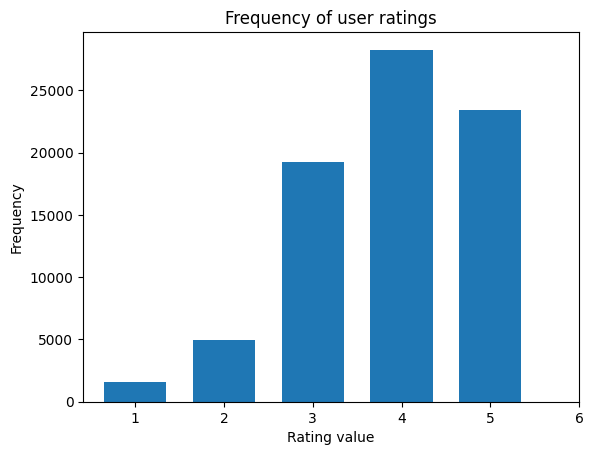

In [4]:
data = ratings_df_init['rating']
bins = [1, 2, 3, 4, 5, 6]

plt.hist(data, bins, align="left", rwidth=0.7)
plt.xticks(bins)
plt.xlabel('Rating value')
plt.ylabel('Frequency')
plt.title('Frequency of user ratings')
plt.show()

In [5]:
denominator = num_users * num_books

sparsity_gr = (1.0 - (num_ratings) * 1.0 / denominator) * 100
print("Ratings dataset sparsity: ", "%.2f" % sparsity_gr)

Ratings dataset sparsity:  99.66


In [6]:
books_df_init = pd.read_csv('./data/books.csv')

books_df_init = pd.DataFrame(books_df_init)
top_5_books = pd.DataFrame(ratings_df_init.groupby('rating').mean().sort_values('rating', ascending=False).head(n=5))

# print(top_20_books)
top20 = []
for bookid in top_5_books.index:
  for x in range(1, len(books_df_init)):
    if books_df_init["id"][x] == bookid:
      top20.append((books_df_init["title"][x]))
    else:
      pass
    
pd.DataFrame(top20, columns = ['Top 5 Highest Rated Books'])

C:\Users\preri\AppData\Local\Temp\ipykernel_1252\150210582.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_5_books = pd.DataFrame(ratings_df_init.groupby('rating').mean().sort_values('rating', ascending=False).head(n=5))


,Top 5 Highest Rated Books
0,The Great Gatsby
1,To Kill a Mockingbird
2,"Twilight (Twilight, #1)"
3,Harry Potter and the Sorcerer's Stone (Harry P...
4,"The Hunger Games (The Hunger Games, #1)"


In [7]:
import os
driver = "org.postgresql.Driver"
url = "jdbc:postgresql://localhost:5432/Books"
table = 'Ratings'
user = 'postgres'
password = 'prerit'
properties = {
     "user": "postgres",
     "password": "prerit"
 }

In [8]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

ratings_schema = StructType([
  StructField("col_id", IntegerType()),
  StructField("user_id", IntegerType()),
  StructField("rating", DoubleType()),
  StructField("book_id", IntegerType()),
  StructField("username", StringType()),
  StructField("isbn10", StringType())
])



In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [10]:

remote_table = spark.read.format("jdbc")\
  .option("driver", driver)\
  .option("inferSchema", ratings_schema) \
  .option("url", url)\
  .option("dbtable", table)\
  .option("user", user)\
  .option("password", password)\
  .load()

In [11]:
remote_table.show()

+------+-------+------+-------+--------+---------+
|col_id|user_id|rating|book_id|username|   isbn10|
+------+-------+------+-------+--------+---------+
|     1|    314|     5|      1|  kaggle|439785960|
|     2|    439|     3|      1|  kaggle|439785960|
|     3|    588|     5|      1|  kaggle|439785960|
|     4|   1169|     4|      1|  kaggle|439785960|
|     5|   1185|     4|      1|  kaggle|439785960|
|     6|   2077|     4|      1|  kaggle|439785960|
|     7|   2487|     4|      1|  kaggle|439785960|
|     8|   2900|     5|      1|  kaggle|439785960|
|     9|   3662|     4|      1|  kaggle|439785960|
|    10|   3922|     5|      1|  kaggle|439785960|
|    11|   5379|     5|      1|  kaggle|439785960|
|    12|   5461|     3|      1|  kaggle|439785960|
|    13|   5885|     5|      1|  kaggle|439785960|
|    14|   6630|     5|      1|  kaggle|439785960|
|    15|   7563|     3|      1|  kaggle|439785960|
|    16|   9246|     1|      1|  kaggle|439785960|
|    17|  10140|     4|      1|

In [12]:
(training, validation, test) = remote_table.randomSplit([0.6, 0.2, 0.2])

# caching data to cut down on cross-validation time later
training.cache()
validation.cache()
test.cache()

DataFrame[col_id: int, user_id: int, rating: int, book_id: int, username: string, isbn10: string]

In [13]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

als_dt = ALS(maxIter=5, regParam=0.25, userCol="user_id", itemCol="book_id", ratingCol="rating", coldStartStrategy="drop", nonnegative = True, implicitPrefs = False) 

In [15]:
def tune_ALS(training, validation, maxIter, regParams, ranks, als_dt):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = als_dt.setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(training)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [16]:
tune_ALS(training, validation, 10, [.15, .20, .25], [10, 20, 50, 70], als_dt)

10 latent factors and regularization = 0.15: validation RMSE is 1.2154396944102956
10 latent factors and regularization = 0.2: validation RMSE is 1.168550579764287
10 latent factors and regularization = 0.25: validation RMSE is 1.1374829952061565
20 latent factors and regularization = 0.15: validation RMSE is 1.1988183343648897
20 latent factors and regularization = 0.2: validation RMSE is 1.1694794362305008
20 latent factors and regularization = 0.25: validation RMSE is 1.1432260399814038
50 latent factors and regularization = 0.15: validation RMSE is 1.1744067212874285
50 latent factors and regularization = 0.2: validation RMSE is 1.161260276497394
50 latent factors and regularization = 0.25: validation RMSE is 1.1415360013911697
70 latent factors and regularization = 0.15: validation RMSE is 1.170369102001147
70 latent factors and regularization = 0.2: validation RMSE is 1.16075309400422
70 latent factors and regularization = 0.25: validation RMSE is 1.142287991459994

The best mode

ALSModel: uid=ALS_ede5244aba41, rank=10

In [17]:
als = ALS(maxIter=10, regParam=0.20, userCol="user_id", itemCol="book_id", ratingCol="rating", coldStartStrategy="drop", nonnegative = True, implicitPrefs = False).setRank(50)

In [18]:
model = als.fit(training)

In [19]:
predictions = model.transform(test)
predictions.show(500)

+------+-------+------+-------+--------+----------+----------+
|col_id|user_id|rating|book_id|username|    isbn10|prediction|
+------+-------+------+-------+--------+----------+----------+
|  2072|  32592|     4|     21|  kaggle|076790818X| 3.8038716|
|  2578|  35982|     2|     26|  kaggle|  60920084| 2.7489264|
|  2851|  19984|     5|     29|  kaggle| 380715430| 4.2271986|
| 10512|   3918|     4|    106|  kaggle| 441172695| 2.8461347|
| 27435|  15727|     2|    275|  kaggle| 375700528| 2.9160173|
| 29011|   3918|     5|    291|  kaggle| 806501901|  2.621475|
| 35411|   6658|     5|    355|  kaggle| 345316509| 3.2280507|
| 38581|  35982|     5|    386|  kaggle| 393329402| 2.9984276|
| 44563|  39285|     5|    446|  kaggle| 312426232|  4.586337|
| 47423|  15727|     3|    475|  kaggle| 143036556| 2.6488135|
| 62010|   3918|     5|    621|  kaggle| 767923820| 2.9256632|
| 70575|  35912|     3|    706|  kaggle| 713998946| 3.0103974|
| 96796|  51123|     4|    968|  kaggle| 307277674|  3.

In [20]:
# Generate n recommendations for all users
ALS_recommendations = model.recommendForAllUsers(numItems = 10)

In [21]:
display(ALS_recommendations.filter(ALS_recommendations['user_id'] == 53423))

DataFrame[user_id: int, recommendations: array<struct<book_id:int,rating:float>>]

In [22]:
# Temporary table
ALS_recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("""SELECT user_id,
                            bookIds_and_ratings.book_id AS book_id,
                            bookIds_and_ratings.rating AS prediction
                        FROM ALS_recs_temp LATERAL VIEW explode(recommendations) exploded_table AS bookIds_and_ratings""")

c:\Users\preri\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [23]:
clean_recs.join(remote_table, ["user_id", "book_id"], "left").filter(remote_table.rating.isNull()).show()

clean_recs_filtered = clean_recs.select("user_id", "book_id", "prediction")

clean_recs_filtered.show()

+-------+-------+----------+------+------+--------+------+
|user_id|book_id|prediction|col_id|rating|username|isbn10|
+-------+-------+----------+------+------+--------+------+
|    251|   4660|  4.426157|  null|  null|    null|  null|
|    762|   9531| 3.5167532|  null|  null|    null|  null|
|   1005|   2767|  2.570981|  null|  null|    null|  null|
|   1395|   1274|  3.349116|  null|  null|    null|  null|
|   1404|   9531| 3.6136947|  null|  null|    null|  null|
|   1877|    365|  4.015662|  null|  null|    null|  null|
|   1877|   5346| 3.8571832|  null|  null|    null|  null|
|   2821|   5508|  4.255337|  null|  null|    null|  null|
|   2848|   2865| 2.9356165|  null|  null|    null|  null|
|   4119|   3885|0.89632994|  null|  null|    null|  null|
|   4538|   9569| 3.7026985|  null|  null|    null|  null|
|   5852| 643301| 4.2801256|  null|  null|    null|  null|
|   6482|   5849|  3.066412|  null|  null|    null|  null|
|   8389|   4806|  2.771323|  null|  null|    null|  nul

In [24]:
new_books = (clean_recs_filtered.join(remote_table, ["user_id", "book_id"], "left").filter(remote_table.rating.isNull()))

In [25]:
new_books_fnl = new_books.select('user_id', 'book_id', 'prediction')

new_books_users = new_books_fnl.filter(new_books_fnl['user_id'] > 53424)

new_books_use = new_books_users.select('user_id', 'book_id', 'prediction')

new_books_fnl.show(500)
new_books_users.show(500)
new_books_use.show(500)

+-------+-------+----------+
|user_id|book_id|prediction|
+-------+-------+----------+
|    251|   4660|  4.426157|
|    762|   9531| 3.5167532|
|   1005|   2767|  2.570981|
|   1395|   1274|  3.349116|
|   1404|   9531| 3.6136947|
|   1877|    365|  4.015662|
|   1877|   5346| 3.8571832|
|   2821|   5508|  4.255337|
|   2848|   2865| 2.9356165|
|   4119|   3885|0.89632994|
|   4538|   9569| 3.7026985|
|   5852| 643301| 4.2801256|
|   6482|   5849|  3.066412|
|   8389|   4806|  2.771323|
|   8501|   1618| 3.9787421|
|   9383|   4407| 2.7040262|
|   9427|    250| 3.5025146|
|   9890|   9531| 3.7286017|
|  10257|   5084|0.88218045|
|  11162|   2865|  4.117569|
|  12694|   9566| 3.8766196|
|  12865|   9569| 3.8860323|
|  14062|   9712|  4.580461|
|  14462|    870| 3.1121595|
|  15040|   2767|  4.131644|
|  15363|   9569| 3.6111166|
|  16455|   2872| 4.8719163|
|  16698|   2095|  4.628224|
|  18024|   2865|  2.278951|
|  19733|   4660| 4.3902655|
|  19998|   7993| 3.9318466|
|  20738|   95

In [26]:
new_books_use.write.option("truncate", "true").jdbc(url=url, table='new_recs', mode='overwrite', properties=properties)